# Initial setups

In [1]:
using JuMP
using Gurobi
env = Gurobi.Env()
using PowerSystems

using Graphs
using MetaGraphsNext
using CairoMakie
using GraphMakie
using SparseArrays
using GraphMakie.NetworkLayout

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


In [2]:
mutable struct Branch
    b::Float64
    p_max::Float64
    v_nom1::Float64
    v_nom2::Float64
    p::Float64
    Branch(b, p_max) = new(b, p_max, 0, 0, 0)
    Branch(b, p_max, v_nom1, v_nom2) = new(b, p_max, v_nom1, v_nom2, 0)
    Branch(b::Branch) = new(b.b, b.p_max, b.v_nom1, b.v_nom2, b.p)
    Branch(b::Branch, p_max) = new(b.b, p_max, b.v_nom1, b.v_nom2, b.p)
end

struct BranchId
    bus1::Int64
    bus2::Int64
end

In [3]:
e_index_for(g::MetaGraph, e::Graphs.SimpleEdge) = g[label_for(g,src(e)), label_for(g,dst(e))]

e_index_for (generic function with 1 method)

## Utility functions

### Parse MatPower files

In [368]:
function network2graph(sys::System)
    g = MetaGraph(
        DiGraph();
        label_type=Int64,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )

    init_p_bus(p_bus, sys, objType, op) = 
        for k in get_components(objType, sys)
            g[k.bus.number] = op(haskey(g,k.bus.number) ? g[k.bus.number] : 0, k.active_power)
        end
    init_p_bus(g, sys, PowerLoad, +)
    init_p_bus(g, sys, Generator, -)
    
    for k in get_components(ACBranch, sys)
        g[k.arc.from.number, k.arc.to.number] = Branch(1/k.x, 10, k.arc.from.base_voltage, k.arc.to.base_voltage)
    end
    
    to_remove = []
    for v in vertices(g)
        if isempty(inneighbors(g,v)) && isempty(outneighbors(g,v))
            push!(to_remove, label_for(g,v))
        end
    end
    foreach(v-> rem_vertex!(g, code_for(g,v)), to_remove)
    
    g
end

network2graph (generic function with 1 method)

### Tune the grid with constraints - indicators on OTS results

In [47]:
add_constraint(g, fun) = foreach(e -> fun(e_index_for(g,e)), edges(g))

set_limitations(branches, lim) = Dict( k => begin
        br_out = Branch(br_in, br_in.v_nom1 == 138.0 ? lim : 10)
    end for (k,br_in) in branches)

function indicators(model)
    sw = [s for s in model[:sw] if value(s) == 0.0]
    ls = [l for l in model[:ls] if value(l) ≠ 0.0]
    sw, ls
end

indicators (generic function with 1 method)

### Drawing

In [8]:
function draw(g_orig::MetaGraph)
    g = copy(g_orig)
    MaxP = maximum(collect(labels(g)) .|> l->abs(g[l]))
    gLabels = [label_for(g, v) for v in vertices(g)]
    to_reverse = []
    for e in edges(g)
        if e_index_for(g, e).p<0
            push!(to_reverse, e)
        end
    end
    for e in to_reverse
        b = e_index_for(g, e)
        b.p = -b.p
        rem_edge!(g, src(e), dst(e))
        g[label_for(g,dst(e)), label_for(g,src(e))] = b
    end

    fig = Figure(size = (800, 600))
    ax = Axis(fig[1, 1])
    graphplot!(ax, g;
        layout = Spring(C=3),
        nlabels = ["$l($(round(g[l], digits=2)))" for l in gLabels],
        node_size = [sqrt(abs(g[l]))/sqrt(MaxP)*30 for l in gLabels],
        node_attr = (marker = [g[l]>=0 ? :rect : :circle for l in gLabels], color= :white, strokecolor = :red, strokewidth = 1,),
        elabels = [repr(round(e_index_for(g, e).p, digits=2)) for e in edges(g)],
        edge_color = [abs(e_index_for(g,e).p)>e_index_for(g,e).p_max ? :red : :green for e in edges(g)],
        arrow_shift = :end,
        )
    hidedecorations!(ax)
    hidespines!(ax)

    ax.aspect = DataAspect()
    display(fig)
end

draw (generic function with 1 method)

In [48]:
function draw_contingency(g, e)
    h = deepcopy(g)
    rem_edge!(h, src(e),dst(e))
    dc_flow!(h)
    draw(h)    
end

draw_contingency (generic function with 1 method)

# Models

## DC-PF with linear algebra

In [9]:
function dc_flow!(g)
    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    flows = p_to_f * [g[label_for(g, v)] for v in vertices(g)]
    for (i,e) in enumerate(edges(g))
        e_index_for(g, e).p = flows[i]
    end
end

dc_flow! (generic function with 1 method)

In [707]:
sys = System(joinpath("data", "case118.m"));
g = network2graph(sys)

Meta graph based on a SimpleDiGraph{Int64} with vertex labels of type Int64, vertex metadata of type Float64, edge metadata of type Branch, graph metadata given by nothing, and default weight 1.0

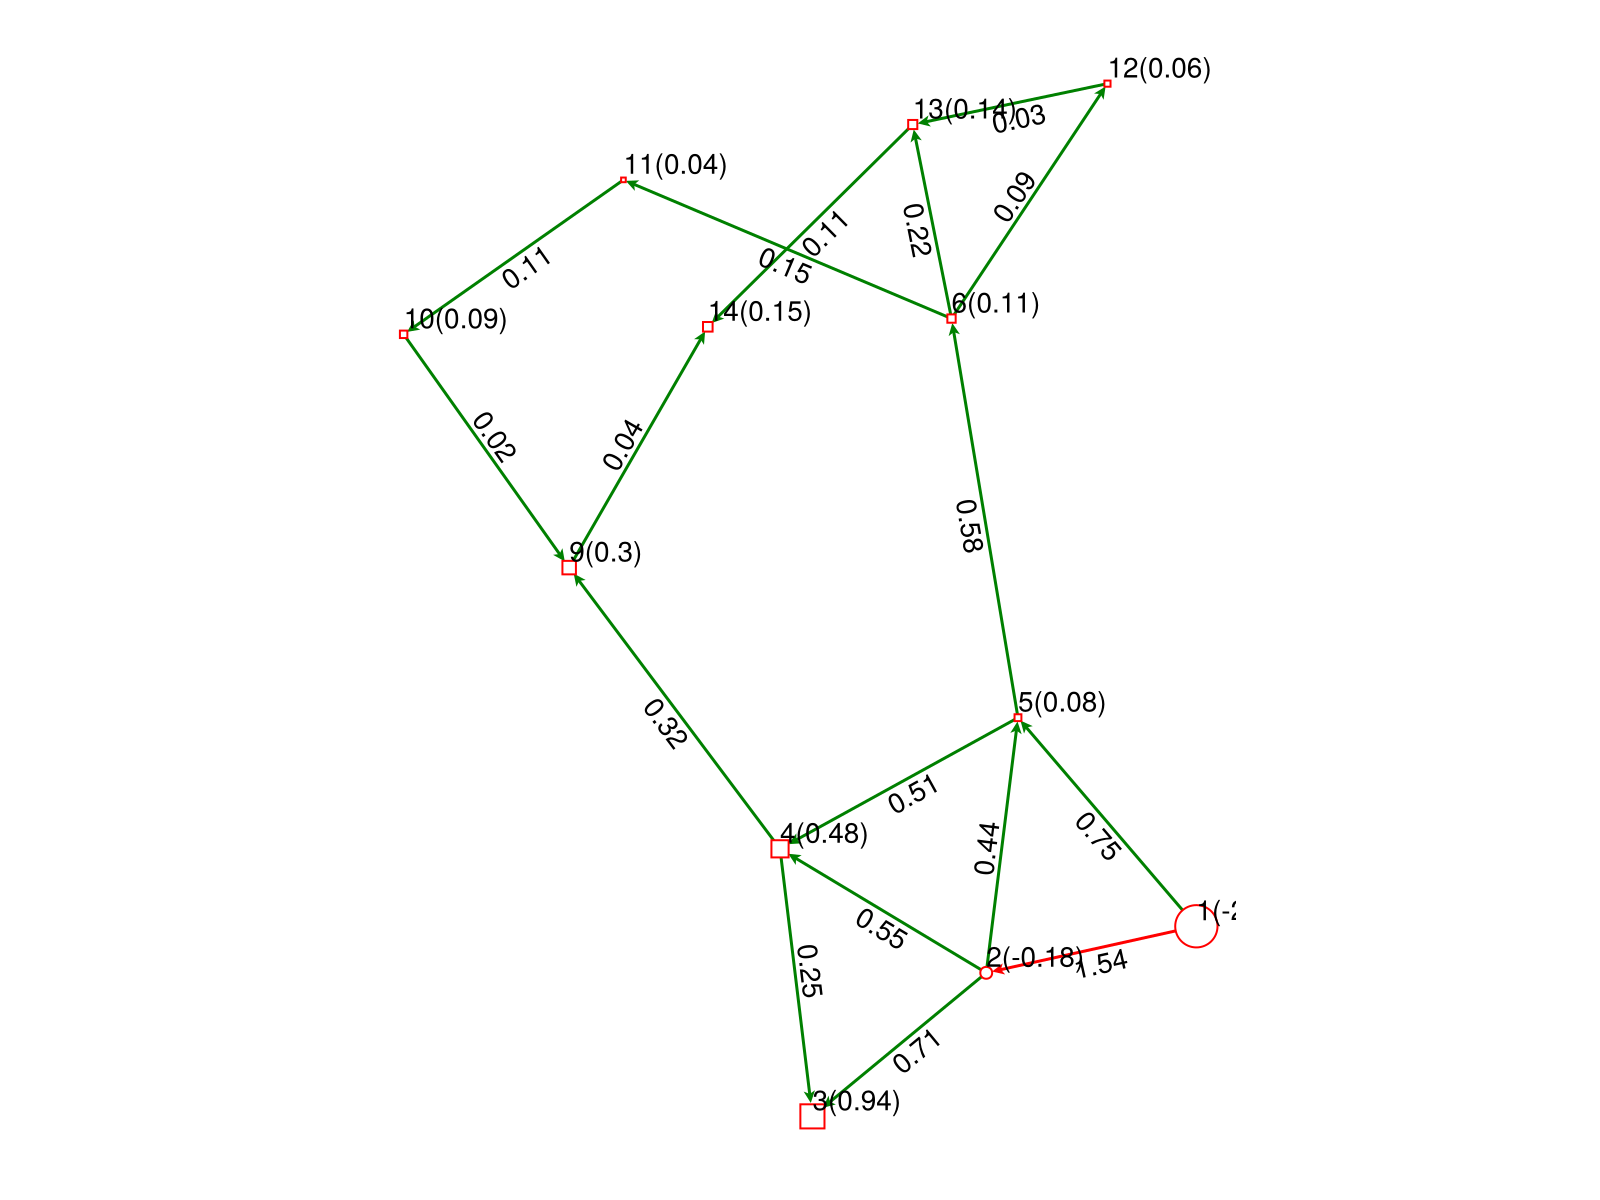

CairoMakie.Screen{IMAGE}


In [725]:
add_constraint(g, b->b.p_max=1)
dc_flow!(g)
draw(g)

## Useless DC PF optim (no optim required)

$$ \rho^* = {\arg\,\min_{\rho, \vec{f}}}\, \rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

In [11]:
function dc_pf_optim(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv

    
    @variable(model, flows[1:ne(g)])
    @variable(model, ρ)
    p = [g[label_for(g, v)] for v in vertices(g)]
    @constraint(model, flows == p_to_f * p)
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    @constraint(model, flows ≤ ρ.*p_max)
    @constraint(model,  -ρ.*p_max ≤ flows)

    @objective(model, Min, ρ)
    model
end

dc_pf_optim (generic function with 1 method)

In [26]:
model = dc_pf_optim(g)
optimize!(model)
display(latex_formulation(model))
print(value(model[:ρ]))
println(solution_summary(model))


$$ \begin{aligned}
\min\quad & ρ\\
\text{Subject to} \quad & [flows_{1} - 1.3928680661594703, flows_{2} + 0.9468042115440387, flows_{3} - 0.4715160698029663, flows_{4} + 0.8700190705109263, flows_{5} - 0.17641644070947576, flows_{6} + 1.0525272823346163, flows_{7} + 0.2705059389780667, flows_{8} + 0.2573039170100172, flows_{9} + 0.890039829826481, flows_{10} + 1.288578815251541, flows_{11} + 0.512906217342258, flows_{12} - 0.1776550753013497, flows_{13} + 1.5520470247631262, flows_{14} + 1.6557613848758808, flows_{15} - 0.29365575175047376, flows_{16} - 1.368101836364301, flows_{17} - 1.8994568955761706, flows_{18} + 1.305991878558238, flows_{19} + 2.0425475212204023, flows_{20} - 0.10695622486020173, flows_{21} - 0.012027896665832621, flows_{22} - 0.30621159835908207, flows_{23} - 0.0828199522791572, flows_{24} - 0.3919644412540262, flows_{25} + 0.5536520264071552, flows_{26} + 0.7807101312471217, flows_{27} + 0.36865850226571256, flows_{28} + 0.3367132075735621, flows_{29} + 0.159483

4.799823324254493* Solver : Gurobi

* Status
  Result count       : 1
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Objective value    : 4.79982e+00
  Objective bound    : 4.79982e+00
  Dual objective value : 4.79982e+00

* Work counters
  Solve time (sec)   : 4.98056e-04
  Barrier iterations : 0
  Node count         : 0



$$ \rho^* = \arg\,\min_{\rho, \vec{f}}\,\max_{\vec{\beta},\vec{u}}\, \rho\\
s.t.\\
\vec{f_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}}$$

ie with $ dim(\vec{u}) = dim(\vec{\beta}) = dim(\vec{\alpha})$
$$ \rho^* = \arg\,\min_{\rho}\, \rho \\
s.t. \\
\vec{F_i} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta_i} \ \forall i\\
\rho \ge \alpha_i \ \forall i\\
|\vec{F_i}| \preceq \alpha_i \overline{\vec{f}} \ \forall i \\
0 \preceq \vec{\alpha} \preceq \vec{u}M \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$


## Secured DC_PF optim ... not relevant.

In [130]:
function secured_dc_pf_optim(g, contingencies)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows_N[1:ne(g)])
    @constraint(model, flows_N == p_to_f * p)
    @variable(model, α_N)
    @constraint(model, flows_N ≤ α_N.*p_max)
    @constraint(model,  -α_N.*p_max ≤ flows_N)

    nb_c = size(contingencies)[1]

    @variable(model, flows[1:nb_c, 1:ne(g)])
    @variable(model, β[1:nb_c, 1:ne(g)])
    @constraint(model, c_beta_pos[i=1:nb_c], β[i,:] ≤ [j==contingencies[i] ? big_M : 0 for j in 1:ne(g)])
    @constraint(model, c_beta_neg[i=1:nb_c], -β[i,:] ≤ [j==contingencies[i] ? big_M : 0 for j in 1:ne(g)])
    @constraint(model, c_flows[i=1:nb_c] , flows[i,:] == p_to_f * p + δ_to_f * β[i,:])
    @constraint(model, c_flows_zero[i=1:nb_c] , flows[i,contingencies[i]] == 0)
    @variable(model, α[1:nb_c])
    @constraint(model, c_flows_lim_pos[i=1:nb_c] ,flows[i,:] ≤ α[i].*p_max)
    @constraint(model, c_flows_lim_neg[i=1:nb_c] ,-α[i].*p_max ≤ flows[i,:])

    @variable(model, ρ)
    @constraint(model, c[i=1:nb_c], α[i] ≤ ρ )
    @constraint(model, α_N ≤ ρ )

    @objective(model, Min, ρ)
    println("/!\\ Ce model n'a pas de sens: il trouve juste une valeur de ρ" )
    
    model
end

secured_dc_pf_optim (generic function with 1 method)

In [292]:
function secured_dc_pf_optim_direct(g, contingencies)
    # model = Model(() -> Gurobi.Optimizer(env))
    model = direct_model(Gurobi.Optimizer())
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    # @variable(model, flows_N[1:ne(g)])
    # @constraint(model, flows_N == p_to_f * p)
    # @variable(model, α_N)
    # @constraint(model, flows_N ≤ α_N.*p_max)
    # @constraint(model,  -α_N.*p_max ≤ flows_N)

    nb_c = size(contingencies)[1]

    @variable(model, β[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c],  β[i,:] .≤ [j==contingencies[i] ? big_M : 0 for j in 1:ne(g)])
    @constraint(model, [i=1:nb_c], -β[i,:] .≤ [j==contingencies[i] ? big_M : 0 for j in 1:ne(g)])

    @variable(model, flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c], flows[i,:] .== p_to_f * p + δ_to_f * β[i,:])
    @constraint(model, [i=1:nb_c], flows[i,contingencies[i]] == 0)
    
    @variable(model, α[1:nb_c+1])
    @constraint(model, [i=1:nb_c], flows[i,:] .≤ α[i].*p_max)
    @constraint(model, [i=1:nb_c], -α[i].*p_max .≤ flows[i,:])

    grb = backend(model)
    columns = Cint.(Gurobi.column.(grb, index.(α)) .- 1)
    ind = vcat([collect(columns[i]) for i in 1:nb_c]...)
    GRBaddgenconstrMax(grb, "maxconstr", columns[nb_c+1], nb_c, ind, 0)
    # @objective(model, Min, α[nb_c+1])
    model
end

secured_dc_pf_optim_direct (generic function with 1 method)

In [460]:
model = secured_dc_pf_optim_direct(g, [1])
# optimize!(model)
display(latex_formulation(model))
# println(value.(model[:α][17]))
# println(value.(model[:α]))
# println(solution_summary(model))

$$ \begin{aligned}
\text{feasibility}\\
\text{Subject to} \quad & -0.4248366013071896 β_{1,1} + 0.33986928104575165 β_{1,2} - 0.130718954248366 β_{1,3} - 0.23529411764705876 β_{1,4} - 0.10457516339869277 β_{1,5} + flows_{1,1} = -1.1102230246251565e-16\\
 & 0.33986928104575154 β_{1,1} - 0.4248366013071895 β_{1,2} + 0.10457516339869288 β_{1,3} + 0.235294117647059 β_{1,4} + 0.1307189542483661 β_{1,5} + flows_{1,2} = -0.9411764705882356\\
 & -0.130718954248366 β_{1,1} + 0.10457516339869288 β_{1,2} - 0.4248366013071896 β_{1,3} + 0.23529411764705888 β_{1,4} - 0.33986928104575154 β_{1,5} + flows_{1,3} = -2.220446049250313e-16\\
 & -0.23529411764705888 β_{1,1} + 0.23529411764705888 β_{1,2} + 0.23529411764705888 β_{1,3} - 0.5294117647058822 β_{1,4} + 0.23529411764705888 β_{1,5} + flows_{1,4} = -0.9411764705882355\\
 & -0.10457516339869288 β_{1,1} + 0.130718954248366 β_{1,2} - 0.33986928104575154 β_{1,3} + 0.23529411764705888 β_{1,4} - 0.4248366013071896 β_{1,5} + flows_{1,5} = -0.94117647058823

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-27


## Secured DC OTS

With $\mathcal{C}$ the set of contingencies, $\mathcal{V}$ the set of edges and $\mathcal{E}$ the set of edges.

$$
\begin{split}
    \rho^* = \arg\,\min_{\pmb{\gamma},\vec{v}, \pmb{\beta}, \pmb{f}, \vec{\rho}}\, & \max_{c}\rho_c +\alpha \sum_{e \in \mathcal{E}}{v_e}\\
    s.t.\\
    \vec{f_c} = \pmb{DA\hat{B}^{-1}} \vec{p} + (\pmb{D - DA\hat{B}^{-1}A^TD})(\vec{\beta_c} + \vec{\gamma_c}) & \quad \forall c \in \mathcal{C} \\
    |\vec{f_c}| \preceq \rho_c \overline{\vec{f_c}} & \quad \forall c \in \mathcal{C} \\
    (1-\vec{v}) \odot \vec{\gamma_c} = 0 & \quad \forall c \in \mathcal{C} \\
    \beta_{c, e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E}\ |\ c\ne e \\
    v_{e} \in \{0,1\} & \quad \forall e \in \mathcal{E} \\
\end{split}
$$

The cost function is the weighted sum of the maximum overload and the sum of line openings. The later term reduces the number of line openings, the weight $\alpha$ can be pretty low so that it does not impede the main cost.

Ensuring connectedness using a fictitious mirror graph with variables $\star$, having with the same switching and 1 source bus is injecting $|\mathcal{V}| - 1$ (no unit as it is fictitious injection), and each of the others is withdrawing $1$, which ensures there is a connected path from any of them to the source bus. This is done for all the contingencies. 

$$
\begin{split}
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{u_c}) = 0 & \quad \forall c \in \mathcal{C} \\
\overrightarrow{f^\star_{c}} \odot (1-\overrightarrow{v}) = 0 & \quad \forall c \in \mathcal{C} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * u_{c,e} = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
(f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}) * v_e = 0 & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e \in \mathcal{E}|dst(e)=i}{f^\star_{c,e}} - \sum_{e \in \mathcal{E}|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$



Which translates into:
$$
\begin{split}
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{u_c}) & \quad \forall c \in \mathcal{C} \\
|\overrightarrow{f^\star_{c}}| \le M * (1-\overrightarrow{v}) & \quad \forall c \in \mathcal{C} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * u_{c,e} & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
|f^\star_{c, e} - \phi^\star_{c, dst(e)} - \phi^\star_{c, src(e)}|  \le M * v_e & \quad \forall (c,e) \in \mathcal{C}\times\mathcal{E} \\
p^\star_i = \sum_{e|dst(e)=i}{f^\star_{c,e}} - \sum_{e|src(e)=i}{f^\star_{c,e}}  & \quad \forall (c, i) \in \mathcal{C}\times\{1..|\mathcal{V}|\} \\
p^\star_i  = 1 & \quad \forall i \in \{1..|\mathcal{V}| - 1\} \\
p^\star_n = - (|\mathcal{V}| - 1) \\
\end{split}
$$


In [723]:
function secured_dc_OTS_optim_direct(g, contingencies)
    model = direct_model(Gurobi.Optimizer())
    grb = backend(model)
    set_optimizer_attribute(model, "LogFile", "my_log_file.txt")
    # set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    outages = collect(contingencies)
    push!(outages, 0)
    nb_c = size(outages)[1]

    @variable(model, v[1:ne(g)], Bin)
    
    @variable(model, γ[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c],  γ[i,:] .≤ v .* big_M)
    @constraint(model, [i=1:nb_c], -γ[i,:] .≤ v .* big_M)

    @variable(model, β[1:nb_c])
    @constraint(model, -β .≤ big_M)
    @constraint(model,  β .≤ big_M)

    @variable(model, flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c], flows[i,:] .== p_to_f * p + δ_to_f * (β[i] .* [outages[i] == j ? 1 : 0 for j=1:ne(g)] .+ γ[i,:]))
    @constraint(model, [i=1:nb_c-1], flows[i, outages[i]] == 0)
    @constraint(model, [i=1:nb_c],  flows[i,:] .≤ (1 .- v) .* big_M)
    @constraint(model, [i=1:nb_c], -flows[i,:] .≤ (1 .- v) .* big_M)
    
    @variable(model, ρ[1:nb_c+1])
    @constraint(model, [i=1:nb_c], flows[i,:] .≤ ρ[i].*p_max)
    @constraint(model, [i=1:nb_c], -ρ[i].*p_max .≤ flows[i,:])

    columns = Cint.(Gurobi.column.(grb, index.(ρ)) .- 1)
    ind = vcat([collect(columns[i]) for i in 1:nb_c]...)
    GRBaddgenconstrMax(grb, "maxconstr", columns[nb_c+1], nb_c, ind, 0)

    u = [j == outages[i] ? 1 : 0 for i=1:nb_c, j=1:ne(g)]
    
    big_M2 = nv(g)
    @variable(model, c_flows[1:nb_c, 1:ne(g)])
    @constraint(model, [i=1:nb_c],  c_flows[i,:] .≤ big_M2.*(1 .- u[i,:]))
    @constraint(model, [i=1:nb_c], -c_flows[i,:] .≤ big_M2.*(1 .- u[i,:]))
    @constraint(model, [i=1:nb_c],  c_flows[i,:] .≤ big_M2.*(1 .- v))
    @constraint(model, [i=1:nb_c], -c_flows[i,:] .≤ big_M2.*(1 .- v))
    
    @variable(model, ϕ[1:nb_c, 1:nv(g)])
    @constraint(model, [i=1:nb_c, j=1:ne(g)], c_flows[i,j] + sum(A[j,k] * ϕ[i,k] for k in 1:nv(g)) ≤ big_M2 * u[i,j] )
    @constraint(model, [i=1:nb_c, j=1:ne(g)], -(c_flows[i,j] - sum(A[j,k] * ϕ[i,k] for k in 1:nv(g))) ≤ big_M2 * u[i,j] )
    @constraint(model, [i=1:nb_c, j=1:ne(g)], c_flows[i,j] + sum(A[j,k] * ϕ[i,k] for k in 1:nv(g)) ≤ big_M2 * v[j] )
    @constraint(model, [i=1:nb_c, j=1:ne(g)], -(c_flows[i,j] - sum(A[j,k] * ϕ[i,k] for k in 1:nv(g))) ≤ big_M2 * v[j] )
    @constraint(model, [i=1:nb_c, k=1:nv(g)-1], sum([A[j,k] * c_flows[i,j] for j=1:ne(g)]) == 1)
    @constraint(model, [i=1:nb_c], sum([A[j,nv(g)] * c_flows[i,j] for j=1:ne(g)]) == 1-nv(g))
    
    @objective(model, Min, ρ[nb_c+1] + 0.01 * sum(v))
    model
end

secured_dc_OTS_optim_direct (generic function with 1 method)

In [718]:
sys = System(joinpath("data", "case14.m"));
g = network2graph(sys)
add_constraint(g, b->b.p_max=1)


In [735]:
contingencies = [1, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15]
g[1,2].p_max = 1.5
model = secured_dc_OTS_optim_direct(g, 1:2)
optimize!(model)
display(solution_summary(model))
display(model)
# display(latex_formulation(model))
# println(value.(model[:α][17]))
display("ρ: $(value.(model[:ρ]))")
display("γ: $(value.(model[:γ]))")
display("v: $(value.(model[:v]))")
display([collect(edge_labels(g))[i] for i in 1:ne(g) if value.(model[:v][i])==1 ])

# display("ϕ: $(value.(model[:ϕ]))")
# display("c_flows: $(value.(model[:c_flows]))")


* Solver : Gurobi

* Status
  Result count       : 2
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 9.64334e-01
  Objective bound    : 9.64334e-01
  Relative gap       : 0.00000e+00
  Dual objective value : 9.64334e-01

* Work counters
  Solve time (sec)   : 3.96313e-01
  Simplex iterations : 2712
  Barrier iterations : 0
  Node count         : 133


A JuMP Model
Minimization problem with:
Variables: 213
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 89 constraints
`VariableRef`-in-`MathOptInterface.ZeroOne`: 17 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 720 constraints
Model mode: DIRECT
Solver name: Gurobi
Names registered in the model: c_flows, flows, v, β, γ, ρ, ϕ

"ρ: [0.9543344954527148, 0.9543344954527148, 0.9543344954527148, 0.9543344954527148]"

"γ: [0.0 0.0 0.0 0.0 0.0 -7.82534108772467e-7 -0.10276976985777779 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 -0.12014120559003597 0.0 -1.2093063672686445e-7 0.0 0.0 -3.531849383389863e-7 0.0 0.0 0.0 -1.0572590170727507e-7 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 -0.12031709361258561 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]"

"v: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"

1-element Vector{Tuple{Int64, Int64}}:
 (2, 5)

In [549]:
using LinearAlgebra
A = [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  0  0;
     -1  0  0  0  0  0  1  0  0  0  0  0  1  0  0  1  0;
      1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0;
      0  1  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0;
      0  0  0  0  0 -1  0  0  0  0  1  0  0  0  0  0  0;
      0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0  1;
      0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0;
      0  0  0  0  0  0  0  0  0 -1 -1  0  0  1  0  0  0;
      0  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0  0;
      0  0  0  0  0  0  0  0  1  0  0  1 -1 -1  0  0  0;
      0  0  0  1  1  0  0  0  0  0  0  0  0  0 -1  0  0;
      0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
B = [1, 1 , 1, 1, 1, 1, 1, 1, 1, 1, 1, -11]
# A = [1 0 1 -2]; B = [32; -4];
X = A \ B

17-element Vector{Float64}:
  4.10759493670886
  1.0189873417721513
  1.0506329113924051
  1.0379746835443038
  0.01898734177215191
 -0.050632911392405666
  0.6497890295358639
  1.5084388185654014
  2.0168776371308015
  0.9430379746835432
  0.9493670886075944
  0.5084388185654013
 -1.3670886075949347
  2.8924050632911364
  0.05696202531645493
  5.824894514767932
  5.175105485232068

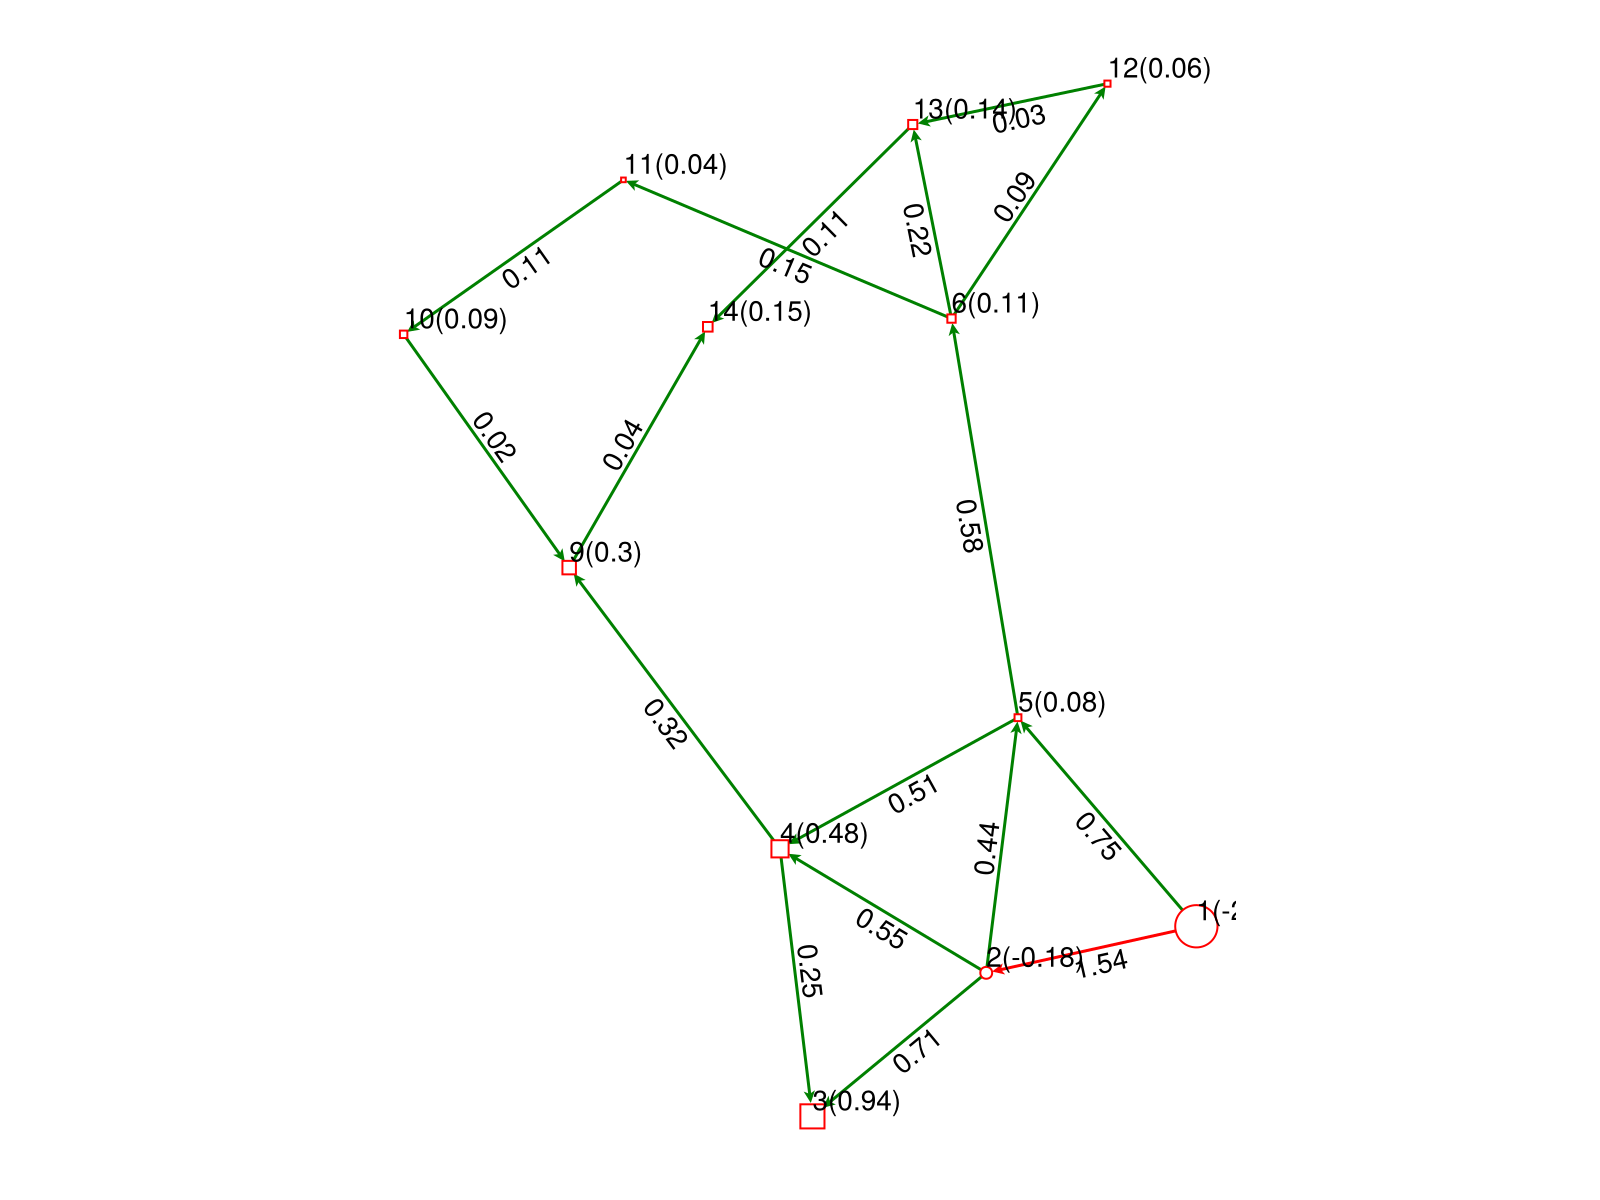

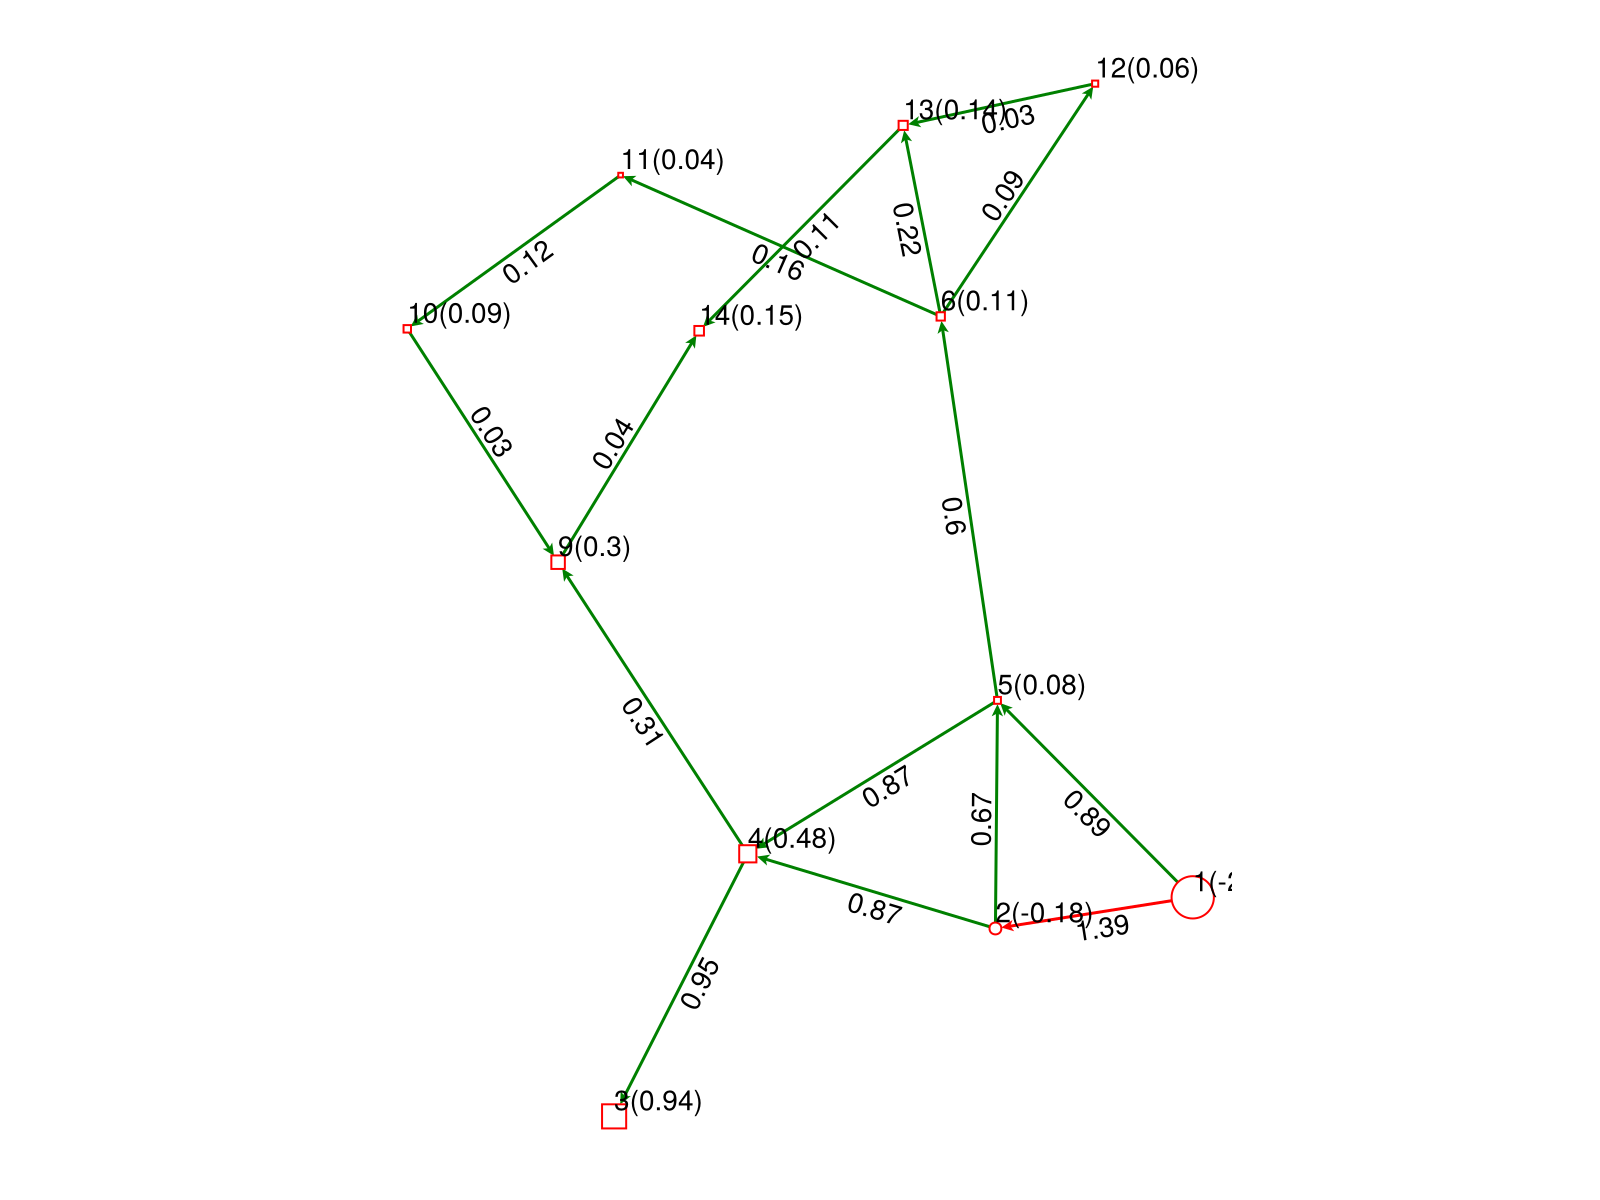

CairoMakie.Screen{IMAGE}


In [338]:
dc_flow!(g)
draw(g)


my_edges = collect(edges(g))
draw_contingency(g,my_edges[8])
# draw_contingency(g,my_edges[16])


## Secured DC PF

$$ \rho^* = \arg\,\max_{\vec{\beta},\vec{u}}\, \min_{\rho}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta}\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1

$$

$$ \rho^* = \arg\,\max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})\vec{\beta} \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1
$$

In [103]:
function secured_dc_pf_optim_2(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * β)

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_pf_optim_2 (generic function with 1 method)

In [478]:
sys = System(joinpath("data", "case14.m"))
# sys = System(joinpath("data", "case1354pegase.m"))
g = network2graph(sys)
add_constraint(g, b->b.p_max=1)



In [104]:
model = secured_dc_pf_optim_2(g)
optimize!(model)
# display(latex_formulation(model))
println(value(model[:ρ]))
println(value.(model[:u]))
println(value.(model[:w]))
# println(value.(model[:flows]))
print(solution_summary(model))

2.2841782604062075
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
* Solver : Gurobi

* Status
  Result count       : 5
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 2.28418e+00
  Objective bound    : 2.28418e+00
  Relative gap       : 0.00000e+00
  Dual objective value : 2.28418e+00

* Work counters
  Solve time (sec)   : 1.58889e-02
  Barrier iterations : 0
  Node count         : 1


## Secured DC OTS


$$ \rho^* = \arg\,\min_{v, \vec{\gamma}}\,\max_{\vec{\beta},\vec{u}}\rho\\
s.t.\\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma})\\
|\vec{f}| \preceq \rho \overline{\vec{f}} \\
(1-\vec{u}) \odot \vec{\beta} = 0 \\
(1-\vec{v}) \odot \vec{\gamma} = 0 \\
u_l \in \{0,1\} \\
\sum_l{u_l} \le 1
v_l \in \{0,1\} \qquad \forall l \\
$$

$$ \rho^* = \arg\,\min_{\vec{v}, \vec{\gamma}} \max_{\vec{w},\vec{u}, \vec{\beta},\rho}\, \rho \\
s.t. \\
\vec{f} = \mathbf{DA\hat{B}^{-1}} \vec{p} + (\mathbf{D - DA\hat{B}^{-1}A^TD})(\vec{\beta} + \vec{\gamma}) \\
|\vec{f}| \preceq (1-\vec{u})M \\
|\vec{f}| \preceq (1-\vec{v})M \\
|\vec{f} - \rho \overline{\vec{f}}| \preceq (1-\vec{w})M\\
|\vec{\beta}| \preceq \vec{u}M \\
|\vec{\gamma}| \preceq \vec{v}M \\
u_l \in \{0,1\} \qquad \forall l \\
\sum_l{u_l} \le 1
$$

$$
w_l \in \{0,1\} \qquad \forall l \\
\sum_{l}{w_l}=1 \\
v_l \in \{0,1\} \qquad \forall l \\
$$

In [115]:
function secured_dc_ots(g)
    model = Model(() -> Gurobi.Optimizer(env))
    set_silent(model)

    A = incidence_matrix(g; oriented = true)'
    D = spdiagm([e_index_for(g,e).b for e in edges(g)]) #TODO: check consistency
    B = A'*D*A
    B_inv = inv(Matrix(B + spdiagm(fill(1/nv(g), nv(g)))))
    p_to_f = D*A*B_inv
    δ_to_f = D - p_to_f*A'*D
    big_M = 100

    p = [g[label_for(g, v)] for v in vertices(g)]
    p_max = [e_index_for(g, e).p_max for e in edges(g)]
    
    @variable(model, flows[1:ne(g)])
    @variable(model, β[1:ne(g)])
    @variable(model, γ[1:ne(g)])
    @variable(model, ρ)
    # @variable(model, 0 ≤ u[i=1:ne(g)] ≤ 1)
    @variable(model, u[1:ne(g)], Bin)
    @variable(model, v[1:ne(g)], Bin)
    @variable(model, w[1:ne(g)], Bin)
    # @variable(model, 0 ≤ w[i=1:ne(g)] ≤ 1)
    
    @constraint(model, c_flows , flows == p_to_f * p + δ_to_f * (β + γ))

    @constraint(model,  flows ≤ ρ.*p_max)
    @constraint(model, -flows ≤ ρ.*p_max)
    
    @constraint(model,  flows .≤ big_M.*(1 .- u))
    @constraint(model, -flows .≤ big_M.*(1 .- u))
    
    @constraint(model,  flows .≤ big_M.*(1 .- v))
    @constraint(model, -flows .≤ big_M.*(1 .- v))
    
    @constraint(model, ρ .- flows .≤ big_M.*(1 .- w))
    @constraint(model, flows .- ρ .≤ big_M.*(1 .- w))

    @constraint(model,  β ≤ big_M .* u)
    @constraint(model, -β ≤ big_M .* u)

    @constraint(model,  γ ≤ big_M .* v)
    @constraint(model, -γ ≤ big_M .* v)

    @constraint(model, sum_u, sum(u) == 1)
    @constraint(model, sum_w, sum(w) == 1)

    @objective(model, Max, ρ)
    model
end

secured_dc_ots (generic function with 1 method)

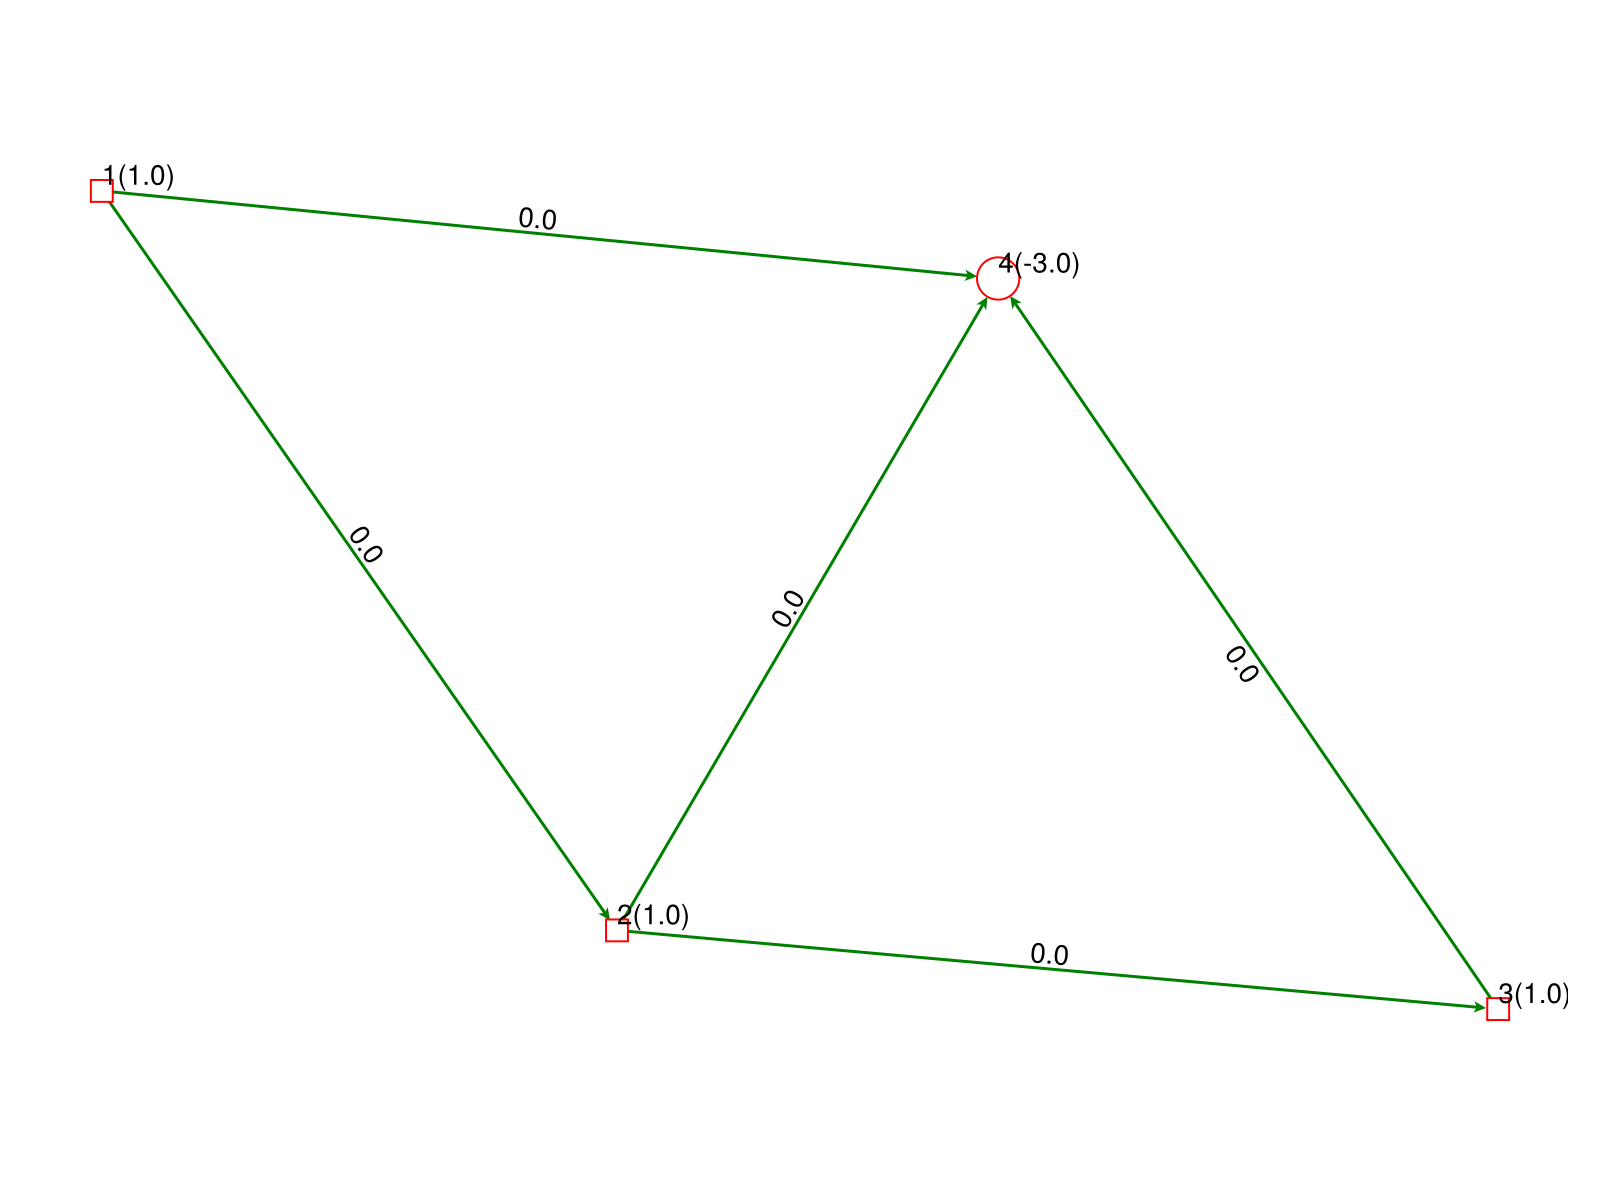

CairoMakie.Screen{IMAGE}


In [458]:
function build_simple_grid()
    g = MetaGraph(
        DiGraph();
        label_type=Int64,
        vertex_data_type = Float64,
        edge_data_type = Branch,
    )
    for i=1:3
        g[i] = 1
    end
    g[4] = -3
    g[1,2] = Branch(1, 1)
    g[2,3] = Branch(1, 1)
    g[3,4] = Branch(1, 1)
    g[2,4] = Branch(1, 1)
    g[1,4] = Branch(1, 1)
    g
end
g = build_simple_grid()
draw(g)


In [459]:
model = secured_dc_ots(g)
# optimize!(model)
display(latex_formulation(model))
# println(value(model[:ρ]))
# println(value.(model[:u]))
# println(value.(model[:w]))
# println(value.(model[:v]))
# println(value.(model[:flows]))
# print(solution_summary(model))

$$ \begin{aligned}
\max\quad & ρ\\
\text{Subject to} \quad & u_{1} + u_{2} + u_{3} + u_{4} + u_{5} = 1\\
 & w_{1} + w_{2} + w_{3} + w_{4} + w_{5} = 1\\
 & flows_{1} + 100 u_{1} \leq 100\\
 & flows_{2} + 100 u_{2} \leq 100\\
 & flows_{3} + 100 u_{3} \leq 100\\
 & flows_{4} + 100 u_{4} \leq 100\\
 & flows_{5} + 100 u_{5} \leq 100\\
 & -flows_{1} + 100 u_{1} \leq 100\\
 & -flows_{2} + 100 u_{2} \leq 100\\
 & -flows_{3} + 100 u_{3} \leq 100\\
 & -flows_{4} + 100 u_{4} \leq 100\\
 & -flows_{5} + 100 u_{5} \leq 100\\
 & flows_{1} + 100 v_{1} \leq 100\\
 & flows_{2} + 100 v_{2} \leq 100\\
 & flows_{3} + 100 v_{3} \leq 100\\
 & flows_{4} + 100 v_{4} \leq 100\\
 & flows_{5} + 100 v_{5} \leq 100\\
 & -flows_{1} + 100 v_{1} \leq 100\\
 & -flows_{2} + 100 v_{2} \leq 100\\
 & -flows_{3} + 100 v_{3} \leq 100\\
 & -flows_{4} + 100 v_{4} \leq 100\\
 & -flows_{5} + 100 v_{5} \leq 100\\
 & -flows_{1} + ρ + 100 w_{1} \leq 100\\
 & -flows_{2} + ρ + 100 w_{2} \leq 100\\
 & -flows_{3} + ρ + 100 w_{3} \leq 1

# Work in progress

$$
\max_{\vec{\beta}, \vec{u}}{\rho} \\
\begin{split}
    \vec{g} = \vec{f} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\vec{p} - (\mathbf{D} -\mathbf{DA}\mathbf{\hat{B}}^{-1}\mathbf{A}^T\mathbf{D})(\vec{\beta} + \mathbf{T}\vec{\gamma}) & \rightarrow \vec{\nu} \\
    \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow \vec{\lambda_{f pos}}\\
    - \vec{f} - (1-\vec{u})M \preceq 0 & \rightarrow  \vec{\lambda_{f neg}}\\
    \vec{\beta} - \vec{u}M \preceq 0 & \rightarrow  \vec{\lambda_{\beta pos}}\\
    -\vec{\beta} - \vec{u}M \preceq 0 & \rightarrow \vec{\lambda_{\beta neg}}\\
    \vec{u} -1 \preceq 0 \ & \rightarrow \vec{\lambda_{u pos}} \\
    -\vec{u} \preceq 0 \ l & \rightarrow  \vec{\lambda_{u neg}} \\
    -1 + \sum_l{u_l} \le 0 & \rightarrow  \lambda_{u sum}
\end{split}
$$

It is a LP, for which the dual function is known.
$$
\max_{\vec{x}} \vec{c} \odot \vec{x} \\
s.t. \\
\mathbf{A} \vec{x} = \vec{b} \\
\vec{x} \preceq 0
$$

Dual
$$
\min_{\vec{\nu}, \vec{\lambda}} -\vec{b} \odot \vec{x} \\
s.t. \\
\vec{c} + \vec{\lambda} + \mathbf{A}^T\vec{\nu} = 0 \\
\vec{\lambda} \succeq 0
$$




In [607]:
collect(enumerate(edge_labels(g)))

17-element Vector{Tuple{Int64, Tuple{Int64, Int64}}}:
 (1, (5, 6))
 (2, (6, 12))
 (3, (6, 11))
 (4, (6, 13))
 (5, (12, 13))
 (6, (10, 11))
 (7, (2, 5))
 (8, (2, 3))
 (9, (2, 4))
 (10, (9, 14))
 (11, (9, 10))
 (12, (3, 4))
 (13, (4, 5))
 (14, (4, 9))
 (15, (13, 14))
 (16, (1, 5))
 (17, (1, 2))